## ARIMA for time series forecasting - Beginner

In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set()

In [3]:
path = '/kaggle/input/dataset/dataset.txt'

df = pd.read_csv(path)

df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    204 non-null    object 
 1   value   204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


In [5]:
df.shape

(204, 2)

We will first use the **Augmented Dickey Fuller test(ADF)** to test is the process is stationary, the null hypothesis is that the presence of a unit root, i.e $\theta_1 =1$ 

In [6]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(df.value.dropna(inplace=False))

print(f"ADF Statistic: %f" % result[0])
print(f"p-value: %f" % result[1])

ADF Statistic: 3.145186
p-value: 1.000000


Since the p-value is greater than the significance level of 0.05, we cannot reject the null hypothesis (H0), the data has a unit root and is non-stationary.

We should now take the differences in order to get it in a stationary process

<Figure size 2000x1000 with 0 Axes>

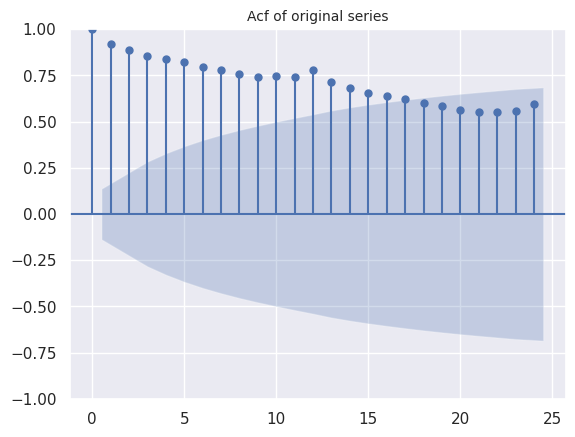

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plot_acf(df.value)
plt.title('Acf of original series', size=10)



plt.show()

Function to calculate the autocorrelation coefficient is $\hat{\rho_k} = \frac{\sum{(x_t - \bar{x})(x_{t-k} - \bar{x})}}{\sum{(x_t - \bar{x_t})^2}}$

In [8]:
def autocorrelation(array, lag):
    num = 0
    den = 0
    x_bar = np.mean(array)
    array = array[::-1]
    for i in range(len(array)-lag-1):
        num += np.sum((array[i] - x_bar) * (array[i+lag] - x_bar))
        den += np.sum((array[i] - x_bar)**2)
    return num/den

My attempt at calculating and plotting the autocorrelation coefficient

In [9]:
go.Figure(data=go.Scatter(x=[i for i in range(1,31)], y=[autocorrelation(df.value, i) for i in range(1,31)]), layout=go.Layout(title='Autocorrelation of original series', width=800, height=400)).show()

<Figure size 2000x1000 with 0 Axes>

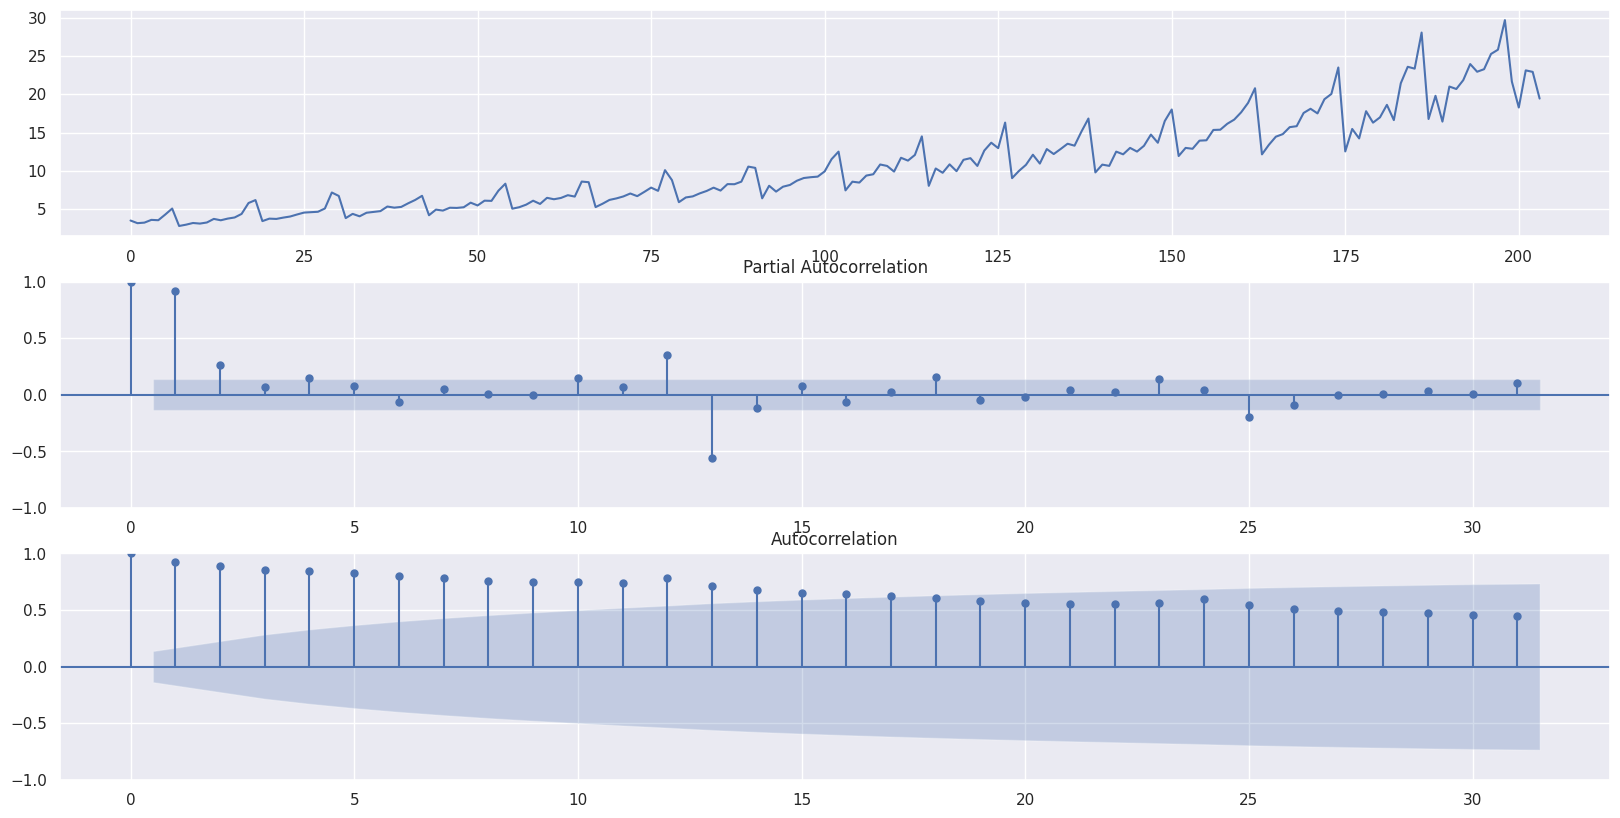

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(20,10))
fig, ax = plt.subplots(3,1,figsize=(20,10))
ax[0].plot(df.value)
plot_acf(df.value.dropna(), ax = ax[2], lags = 31)
plot_pacf(df.value.dropna(), ax = ax[1], lags = 31)
plt.show()

From the plots you can clearly see that there is a unit root, i.e $|\theta| >= 1$, we can instead take first or second order differencing but we will test for both

**First order differencing**

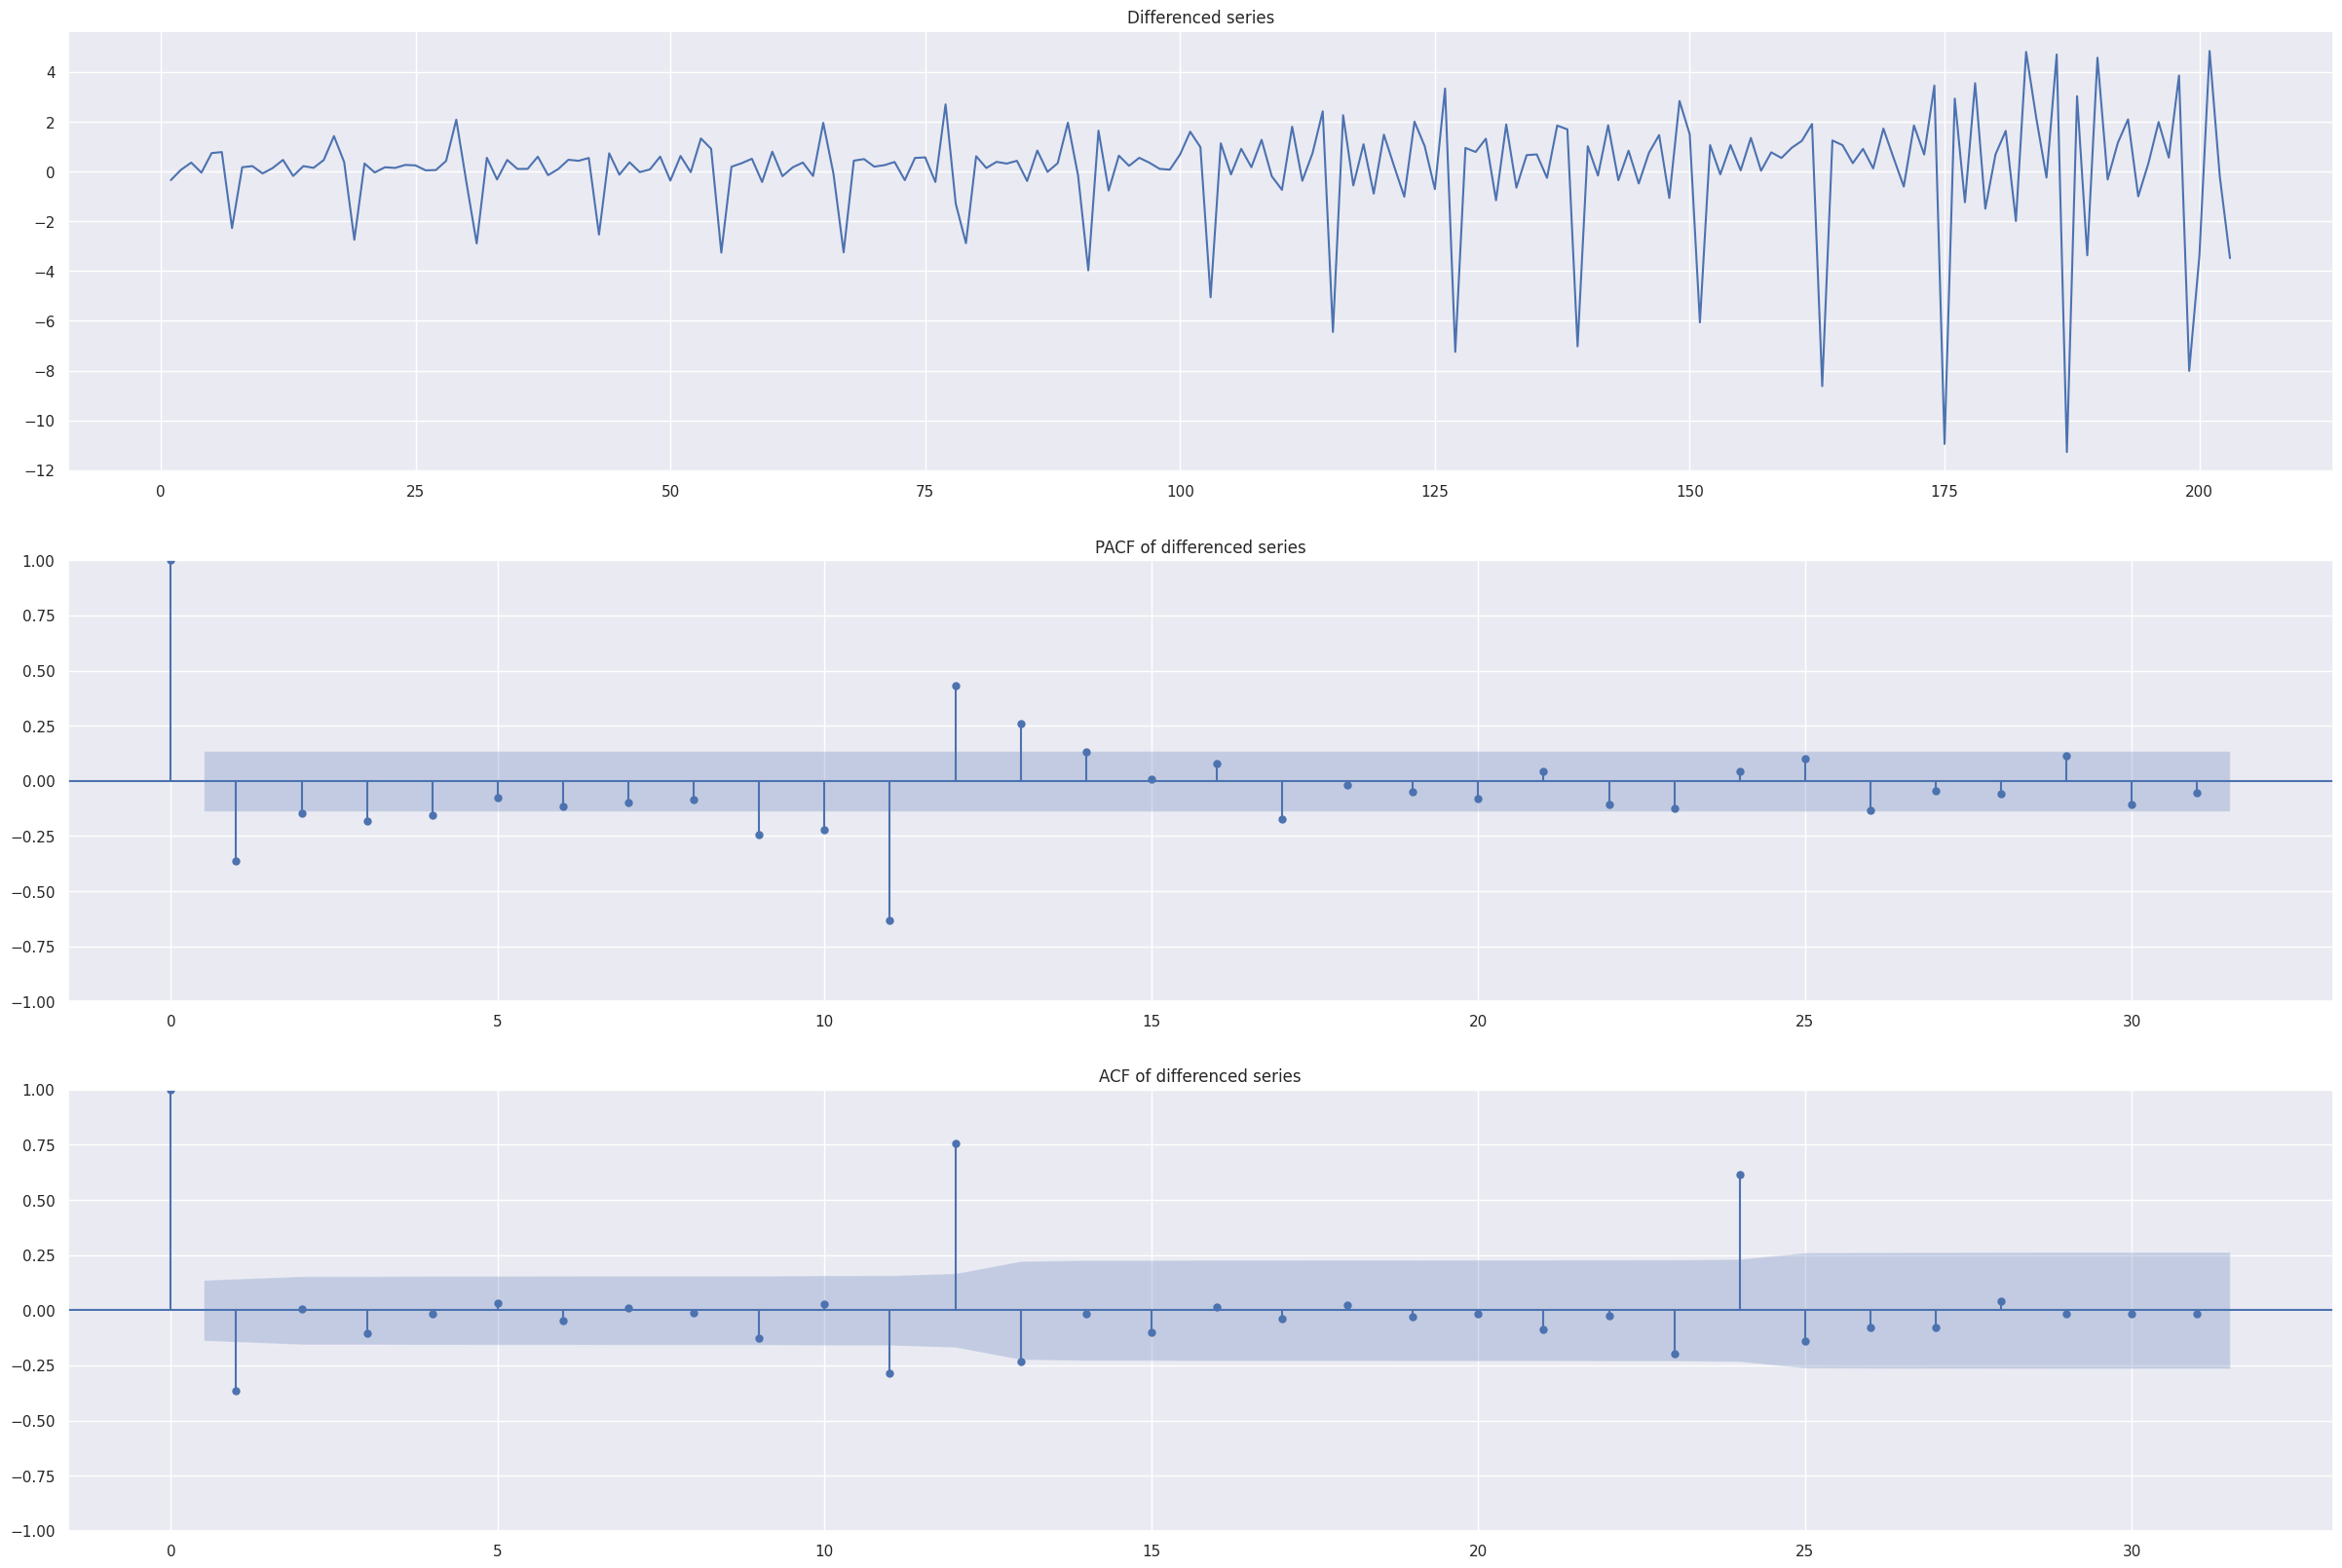

In [11]:
fig, ax = plt.subplots(3,1,figsize=(30,20))
ax[0].plot(df.value.diff())
plot_acf(df.value.diff().dropna(), ax = ax[2], lags = 31)
plot_pacf(df.value.diff().dropna(), ax = ax[1], lags = 31, method='ywmle')
ax[0].set_title('Differenced series')
ax[1].set_title('PACF of differenced series')
ax[2].set_title('ACF of differenced series')
plt.show()

**Second order differencing**

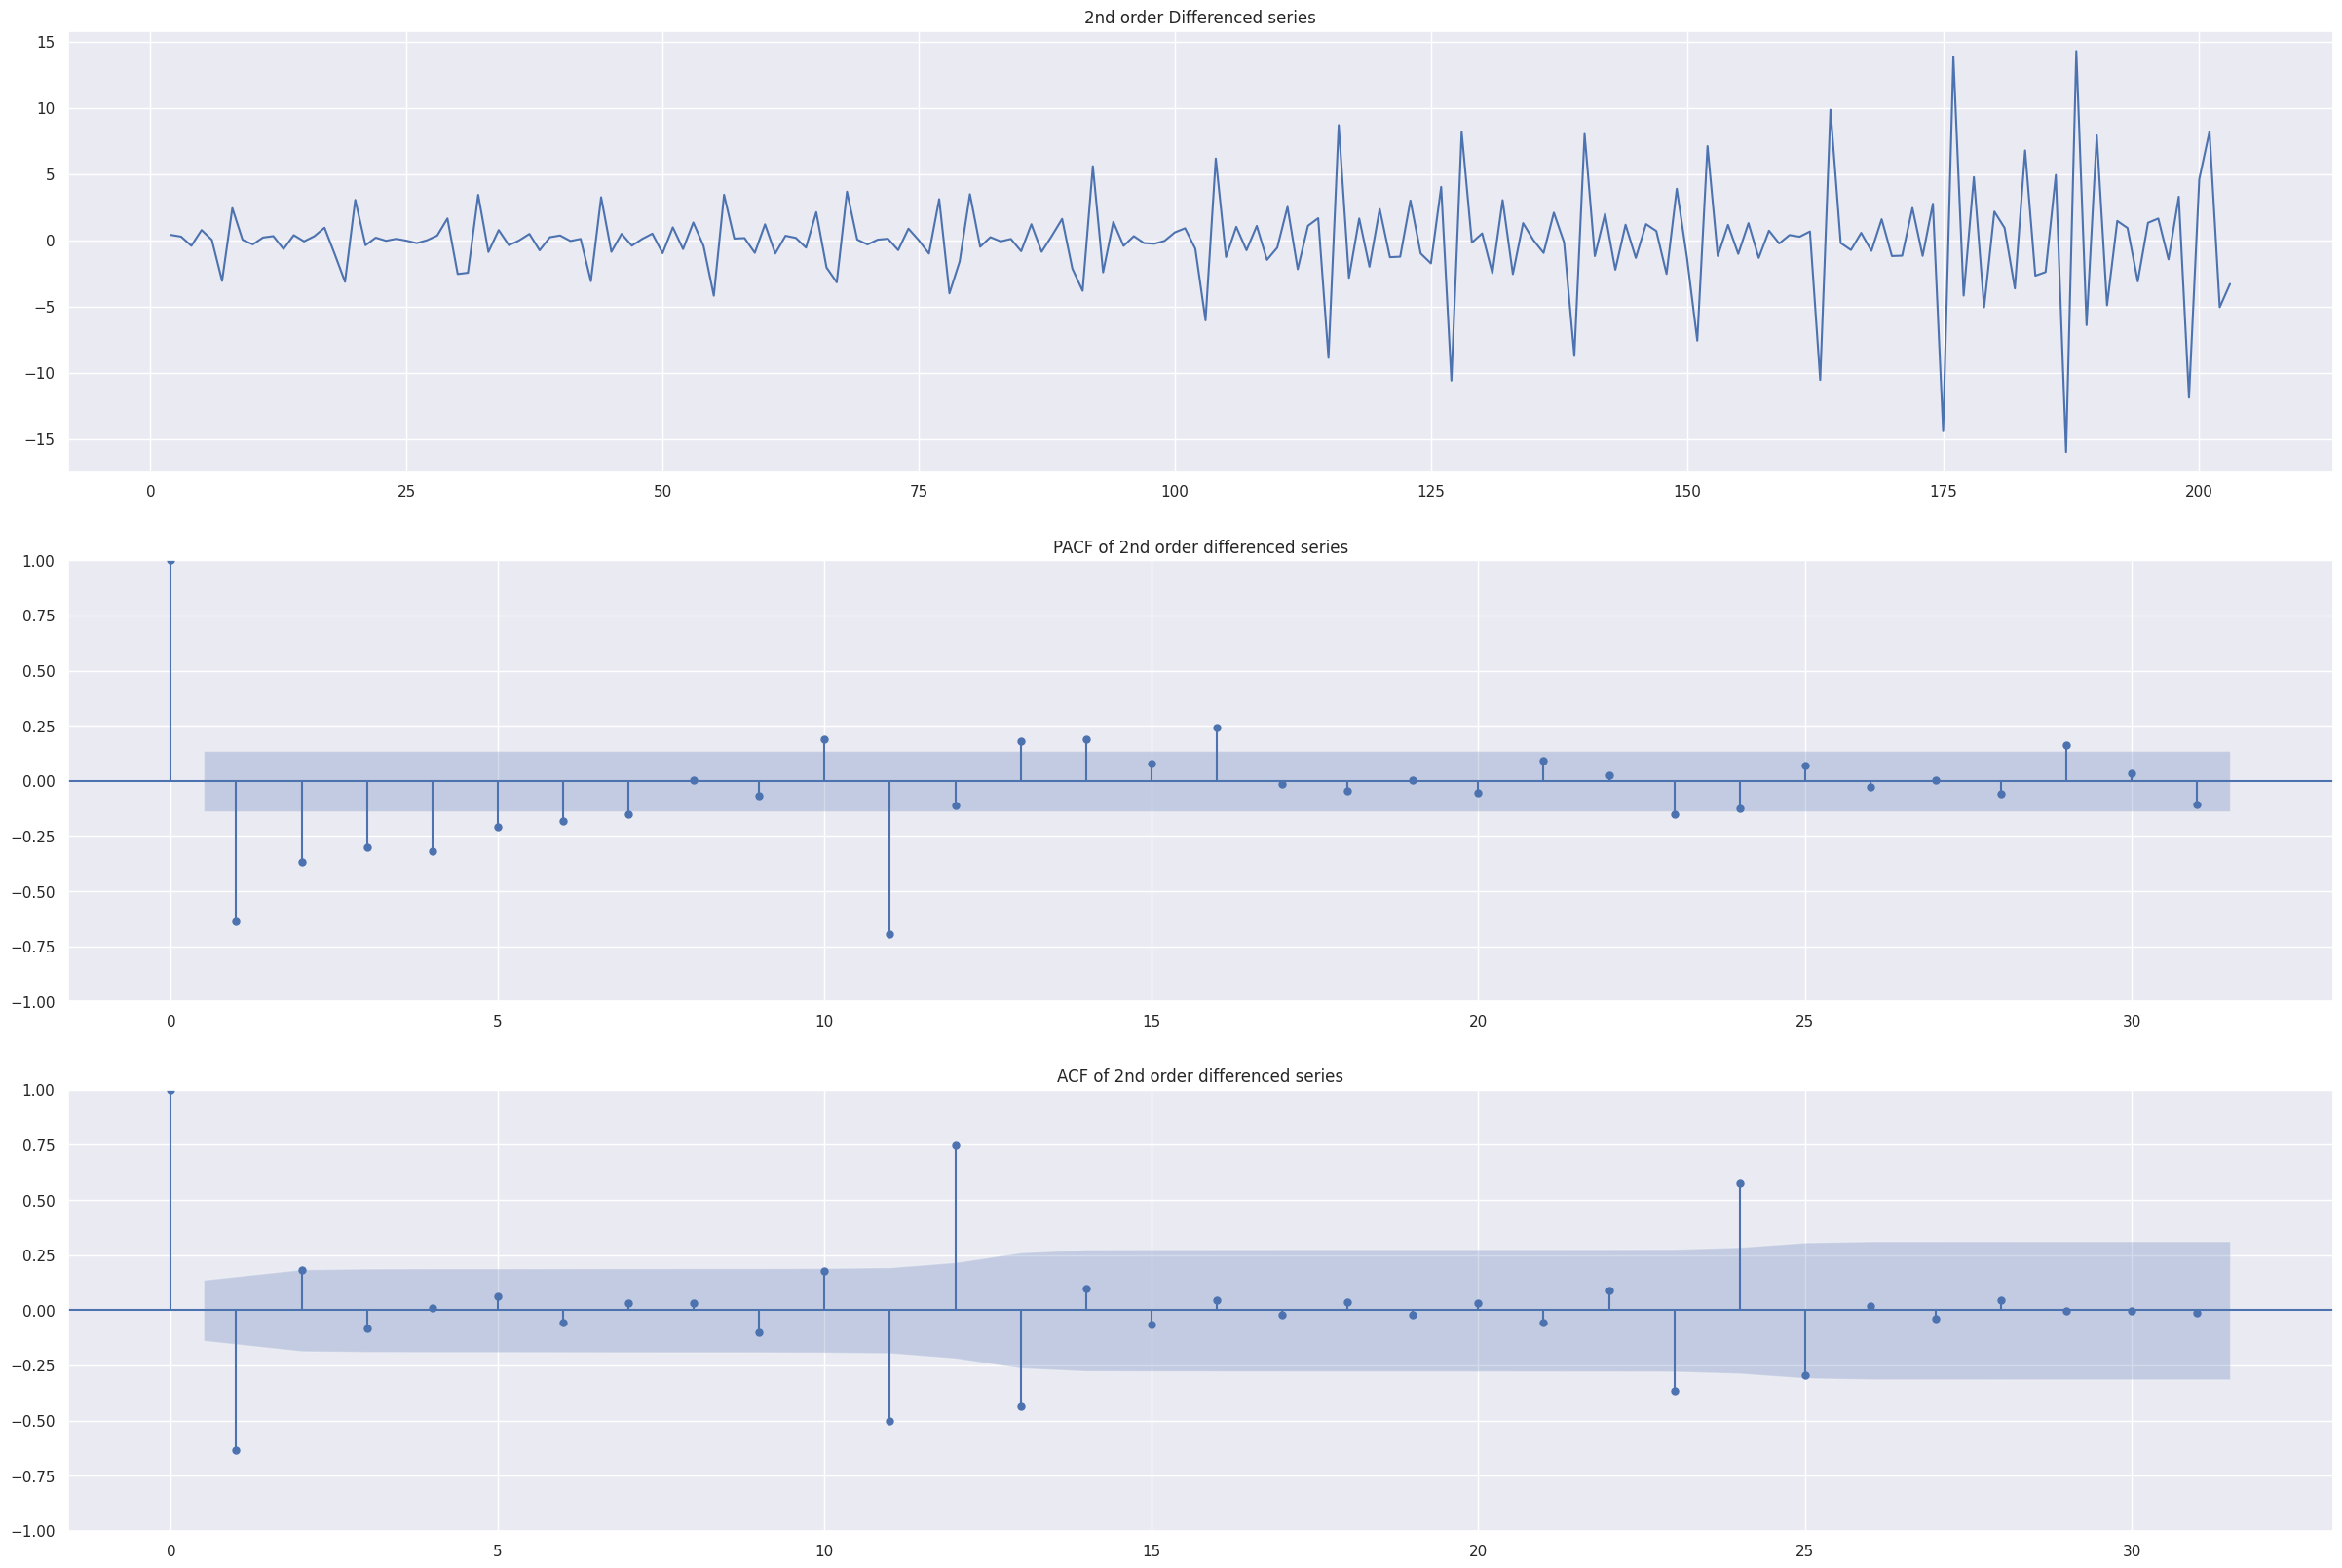

In [12]:
fig, ax = plt.subplots(3,1,figsize=(30,20))
ax[0].plot(df.value.diff().diff())
plot_acf(df.value.diff().diff().dropna(), ax = ax[2], lags = 31)
plot_pacf(df.value.diff().diff().dropna(), ax = ax[1], lags = 31, method='ywmle')
ax[0].set_title('2nd order Differenced series')
ax[1].set_title('PACF of 2nd order differenced series')
ax[2].set_title('ACF of 2nd order differenced series')
plt.show()

We can now see that after taking the 2nd order differences, we have achieved stationarity as the values are centered around the means and the variance is relatviely constant

Looking at the Partial autocorrelation, we can see that the is of order 1 significance as the PACF coefficient at lag 1 is above the 95% confidence interval so we obtain a p value of 1

P = 1

We will take a look at the ACF diagram for first differences to tell us how many AR terms are required to be removed

[]

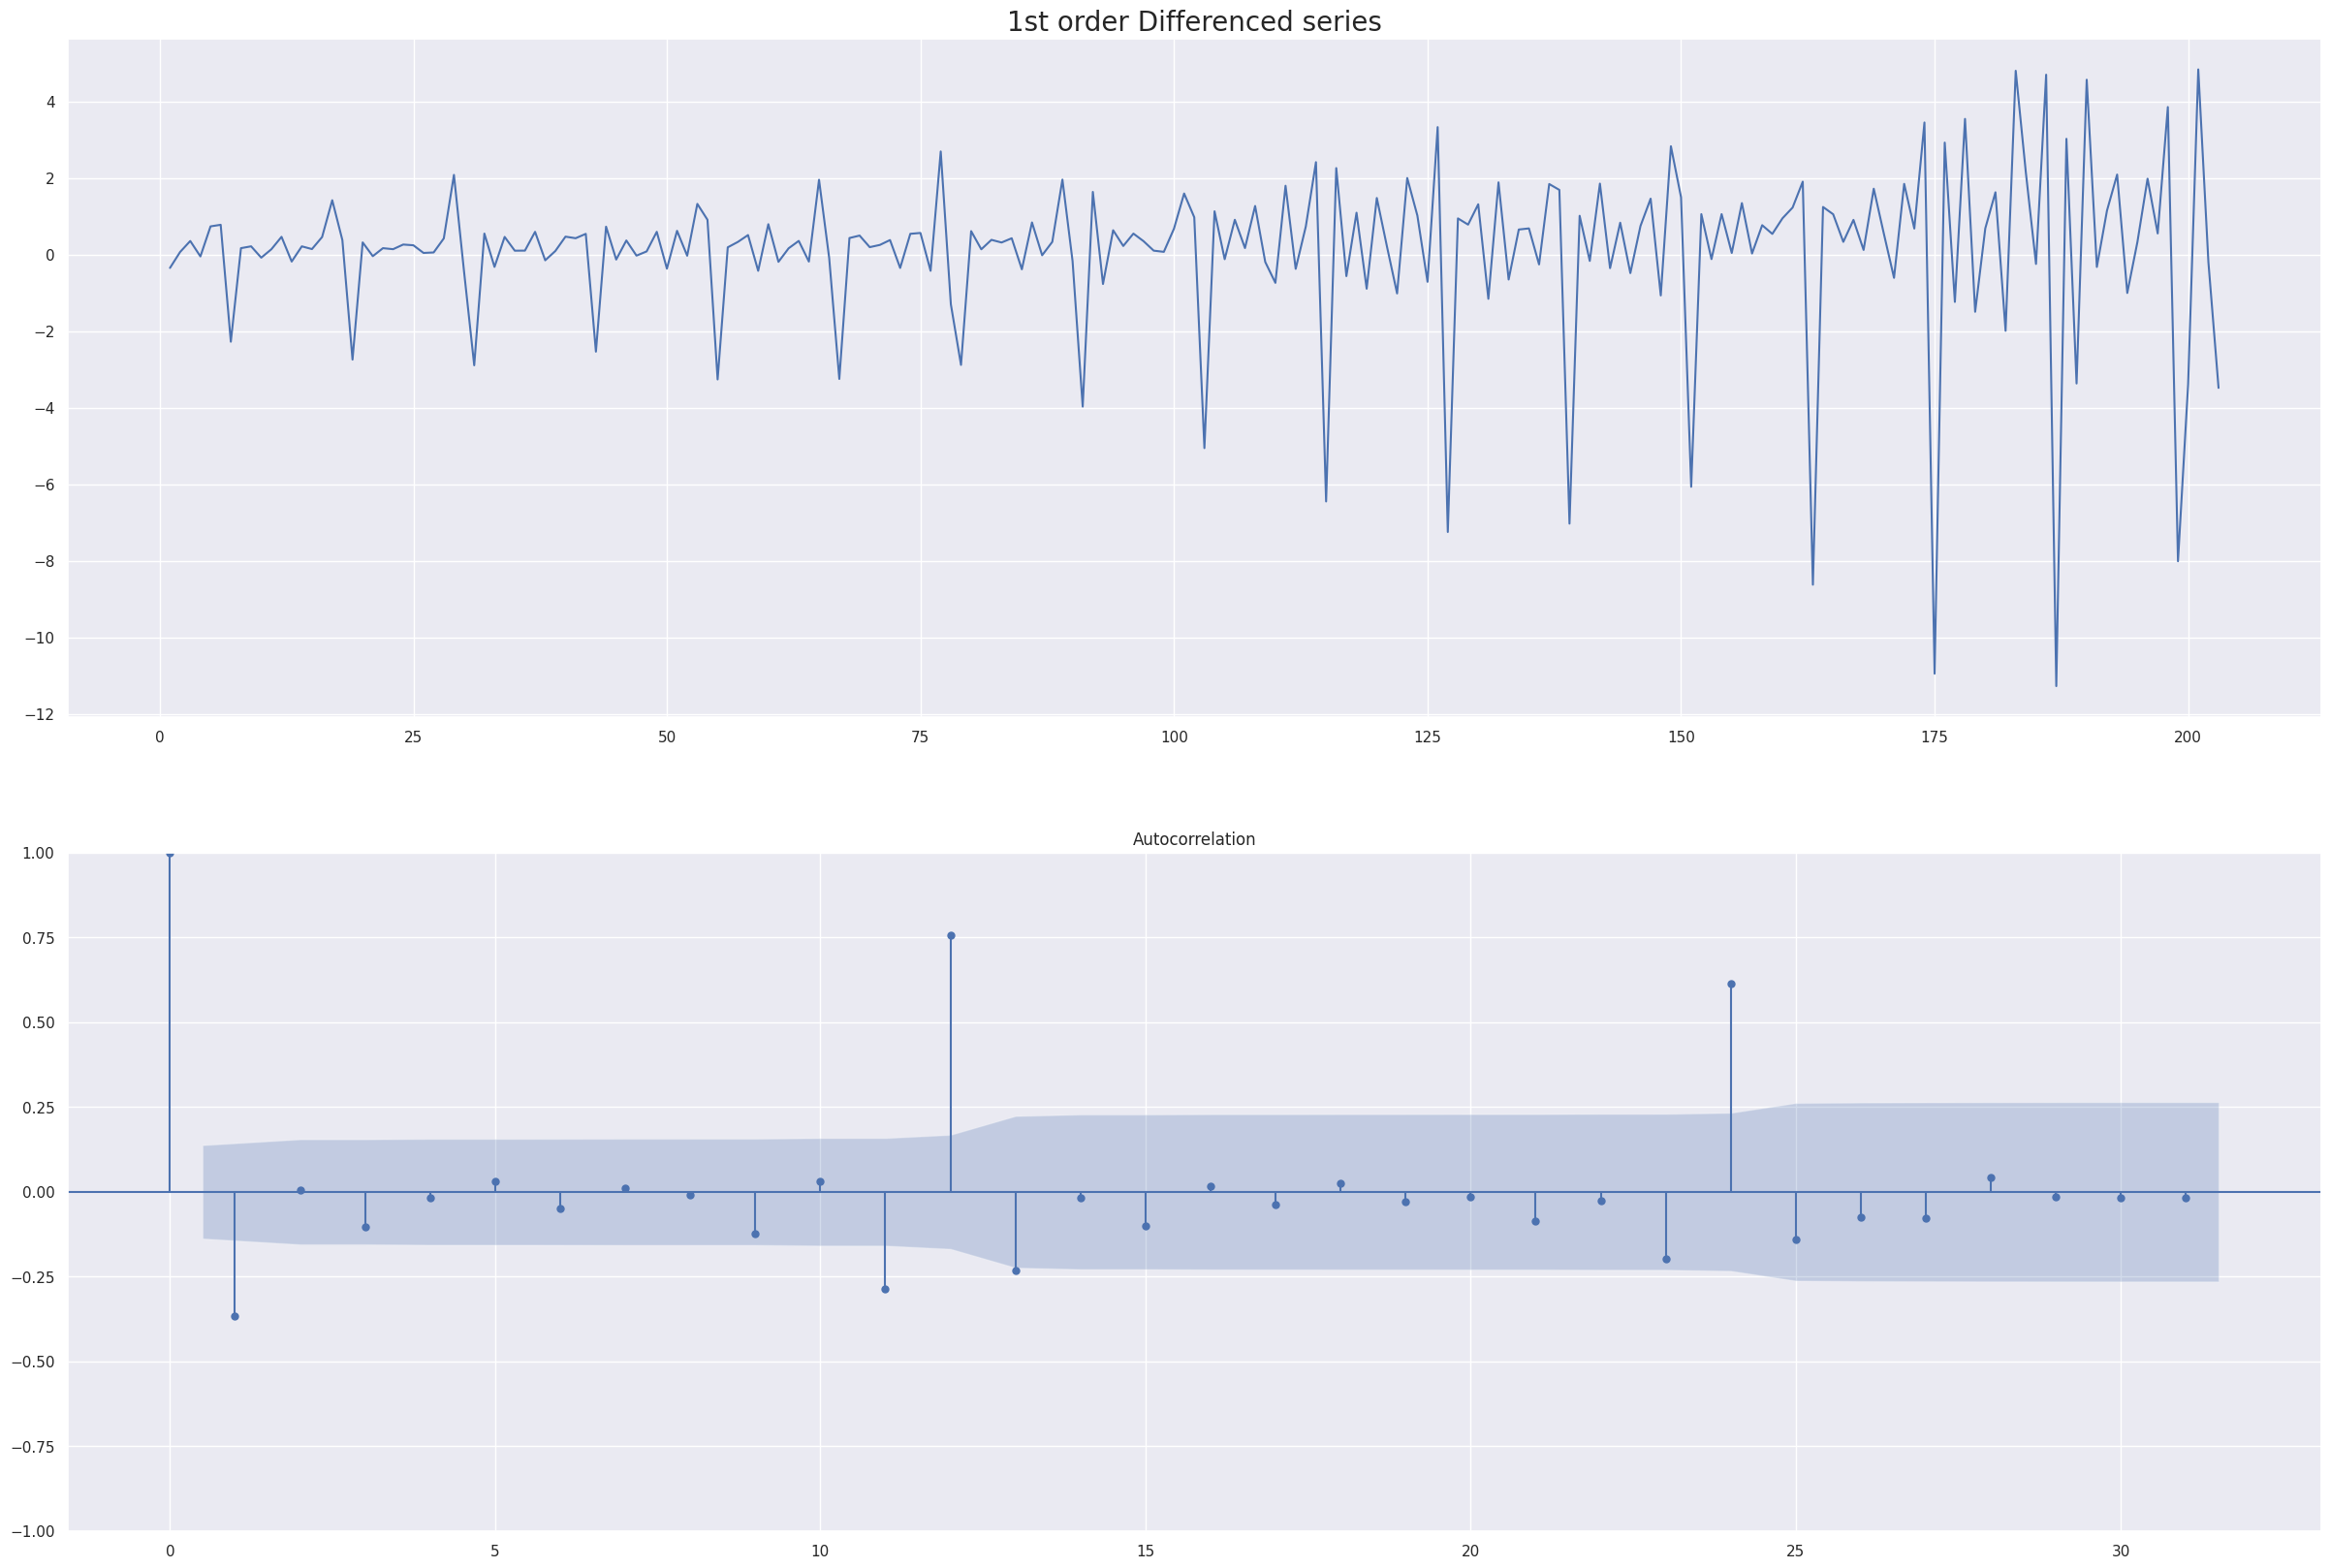

In [13]:
fig, ax = plt.subplots(2,1,figsize=(30,20))
ax[0].plot(df.value.diff().dropna(), label='1st order')
plot_acf(df.value.diff().dropna(), ax = ax[1], lags = 31)

ax[0].set_title('1st order Differenced series', size =20)
plt.plot()

We can see that the first 2 lags are well above the significance line so we will set q as 2, meaning we will include 2 moving average lags in our arima model

q = 2


**Now that we have chosen our values for p and q we can build out our ARIMA model**

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -424.570
Date:                Mon, 22 Jul 2024   AIC                            857.140
Time:                        09:55:31   BIC                            870.393
Sample:                             0   HQIC                           862.502
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4178      0.356      1.174      0.240      -0.280       1.115
ma.L1         -0.9546      0.377     -2.531      0.011      -1.694      -0.215
ma.L2          0.0969      0.272      0.356      0.7

The MA(2) coefficient has a really high p-value, therefore it does not seem to be very significant and is rejected at the 95% confidence interval so we will remove the MA(2) term, it should idealyl be less that 0.05

In [15]:
# 1,1,1 ARIMA Model
model  = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -424.762
Date:                Mon, 22 Jul 2024   AIC                            855.524
Time:                        09:55:42   BIC                            865.463
Sample:                             0   HQIC                           859.545
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.735
sigma2         3.8327      0.259     14.790      0.0

The model AIC is lower for 1,1,1 models than for 1,1,2, which is good as $AIC = 2k - 2ln(\hat{L})$  
<br>
i.e. $AIC=2*k - 2*ln(Loglikelihood)$
<br>
where k = Number of parameters
<br>
<br>
AIC (order 1,1,2) = $2*4 - 2*-424.570 = 857.14$
<br>
AIC (order 1,1,1) = $2*3 - 2*-424.764 = 855.524$

The Bayesian Information criterion is the stricter model compared to Akaike information criterion as it penalises more complex models more heavily:
<br>
<br>
The formula for BIC is:
<br>
<br>
$BIC = ln(N)*k -(2 * Loglikelihood)$
<br>where $k$ = Number of parameters and $N$ = Number of observations
<br>
<br>
BIC (order 1,1,2) = $ln(204)*5 - 2*-424.570 \approx 870.393 $
<br>
BIC (order 1,1,1) = $ln(204)*4 - 2*-424.764 \approx 865.463 $
<br>
<br>
The key difference is that the Schwarz Bayesian Information Criterion (BIC) includes a term of $+ln(N) \cdot k$, whereas the Akaike Information Criterion (AIC) includes a term of $+2 \cdot k$. Therefore, BIC takes into account the number of observations, and as the number of observations increases, the impact of having a large number of coefficients ($k$) on the Information Criterion score is greater.

**Observation**
<br>
The ARIMA(1,1,1) model has a slightly lower AIC (855.524 < 857.14) and a lower BIC (865.463 < 870.393) this indicates that this model is better
<br>
<br>
Notice how the difference between the AIC (857.14 - 855.524 = 1.616) is less than the difference between the BIC (870.393 - 865.463 = 4.93), so the BIC has penalised the additional number of parameters a lot more.


**Lets now plot the residual** to determine if there have a constant variance and mean - this is just to check the the model is following Gaussian principles

In [16]:
import plotly.figure_factory as ff
df_resid = pd.DataFrame(model_fit.resid, columns=['residuals'])

fig1 = ff.create_distplot([df_resid.residuals], ['residuals'], ['KDE Plot'], histnorm='probability density')
fig2 = go.Figure(go.Scatter(x=df_resid.index, y=df_resid.residuals, name='Residuals', showlegend=False))

fig = make_subplots(rows=1, cols=2, subplot_titles=('Residuals', 'Histogram of residuals'))
fig.add_trace(fig1['data'][0], row=1, col=2)
fig.add_trace(fig2['data'][0], row=1, col=1)

fig.update_layout(height=500, width=1000)
fig.show()

The residuals seem to be fine with the error terms centered around 0, and the error terms follow a normal distribution, they therefore satisfy the following gaussian condition $\varepsilon_t\sim N(0,\sigma^2_\varepsilon)$

**Plot actual vs predicted**
<br>
We can now plot the predicted values against the actual to roughly see how well our model predicts, to do this we use hte .plotpredict() method

In [17]:
df_pred = pd.DataFrame(model_fit.predict(dynamic=False).values, columns=['predictions'])
np.array(df_pred.index)

fig= go.Figure()
fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred.predictions, name='Forecasted price'))
fig.add_trace(go.Scatter(x=df.index, y=df.value, name='Original Price'))

fig.update_layout(
    height=500, 
    width=1000,
    title='Predictions vs Original',
    xaxis_title='Time',
    yaxis_title='Value')
fig.show()

When we sent **dynamic=False**, the model uses in-sample lagged values for prediction, conversely if **dynamic=True** then the foreasts of the lagged values are used. This will basically mean that the model is only predicting the forecast one period ahead each time.


This ARIMA model seems to predict pretty well hoever we cannot say that this is the best model because we havent actually forecasted into the future and compared the forecast with actual values, this has only been backtested
<br>
<br>
<br>
To Really validate how good the model is, we will do **Out-of-time** Cross validation

This is a method used for validating the performance of a predictive model. It is particularly important in time series analysis where the data is collected over time.

In out-of-time cross-validation:

**Training Period**: A model is trained on data from a certain time period (the training set).

**Validation Period**: The model is then validated on a later time period (the validation set) that it hasn't seen during training.

**No Overlapping**: The training and validation periods do not overlap. The model is not aware of any data in the validation set during the training phase.

**Repeating the Process**: The process is repeated multiple times, each time shifting the training and validation periods forward in time. This helps in evaluating the model's performance across various time periods.

This approach simulates how the model would perform in a real-world scenario where it is used to make predictions on data from a time period it has not seen before.

Out-of-time cross-validation is especially important in time series analysis because standard cross-validation methods (like k-fold cross-validation) can introduce data leakage and lead to overly optimistic estimates of model performance.

Keep in mind that when performing out-of-time cross-validation, it's crucial to maintain the temporal order of the data to accurately simulate real-world scenarios.


In [18]:
train = df.value[:85]
test = df.value[85:]

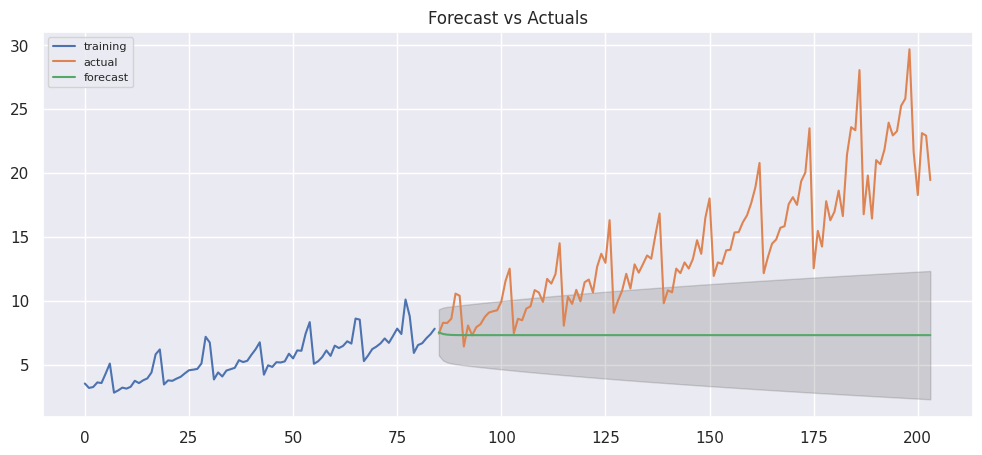

In [19]:
# Build Model
model = ARIMA(train.values, order=(1,1,1))  
fitted_1_1_1 = model.fit()

# Forecast with 95% CI
forecast_results = fitted_1_1_1.get_forecast(steps=119)
fc = forecast_results.predicted_mean
conf_int = forecast_results.conf_int(alpha=0.05)  # alpha=0.05 for 95% CI

lower_ci = pd.Series([i[0] for i in conf_int], index = test.index)
upper_ci = pd.Series([i[1] for i in conf_int], index = test.index)


fc_series = pd.Series(fc, index=test.index)
# Make as pandas series
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.fill_between(lower_ci.index, lower_ci, upper_ci, color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

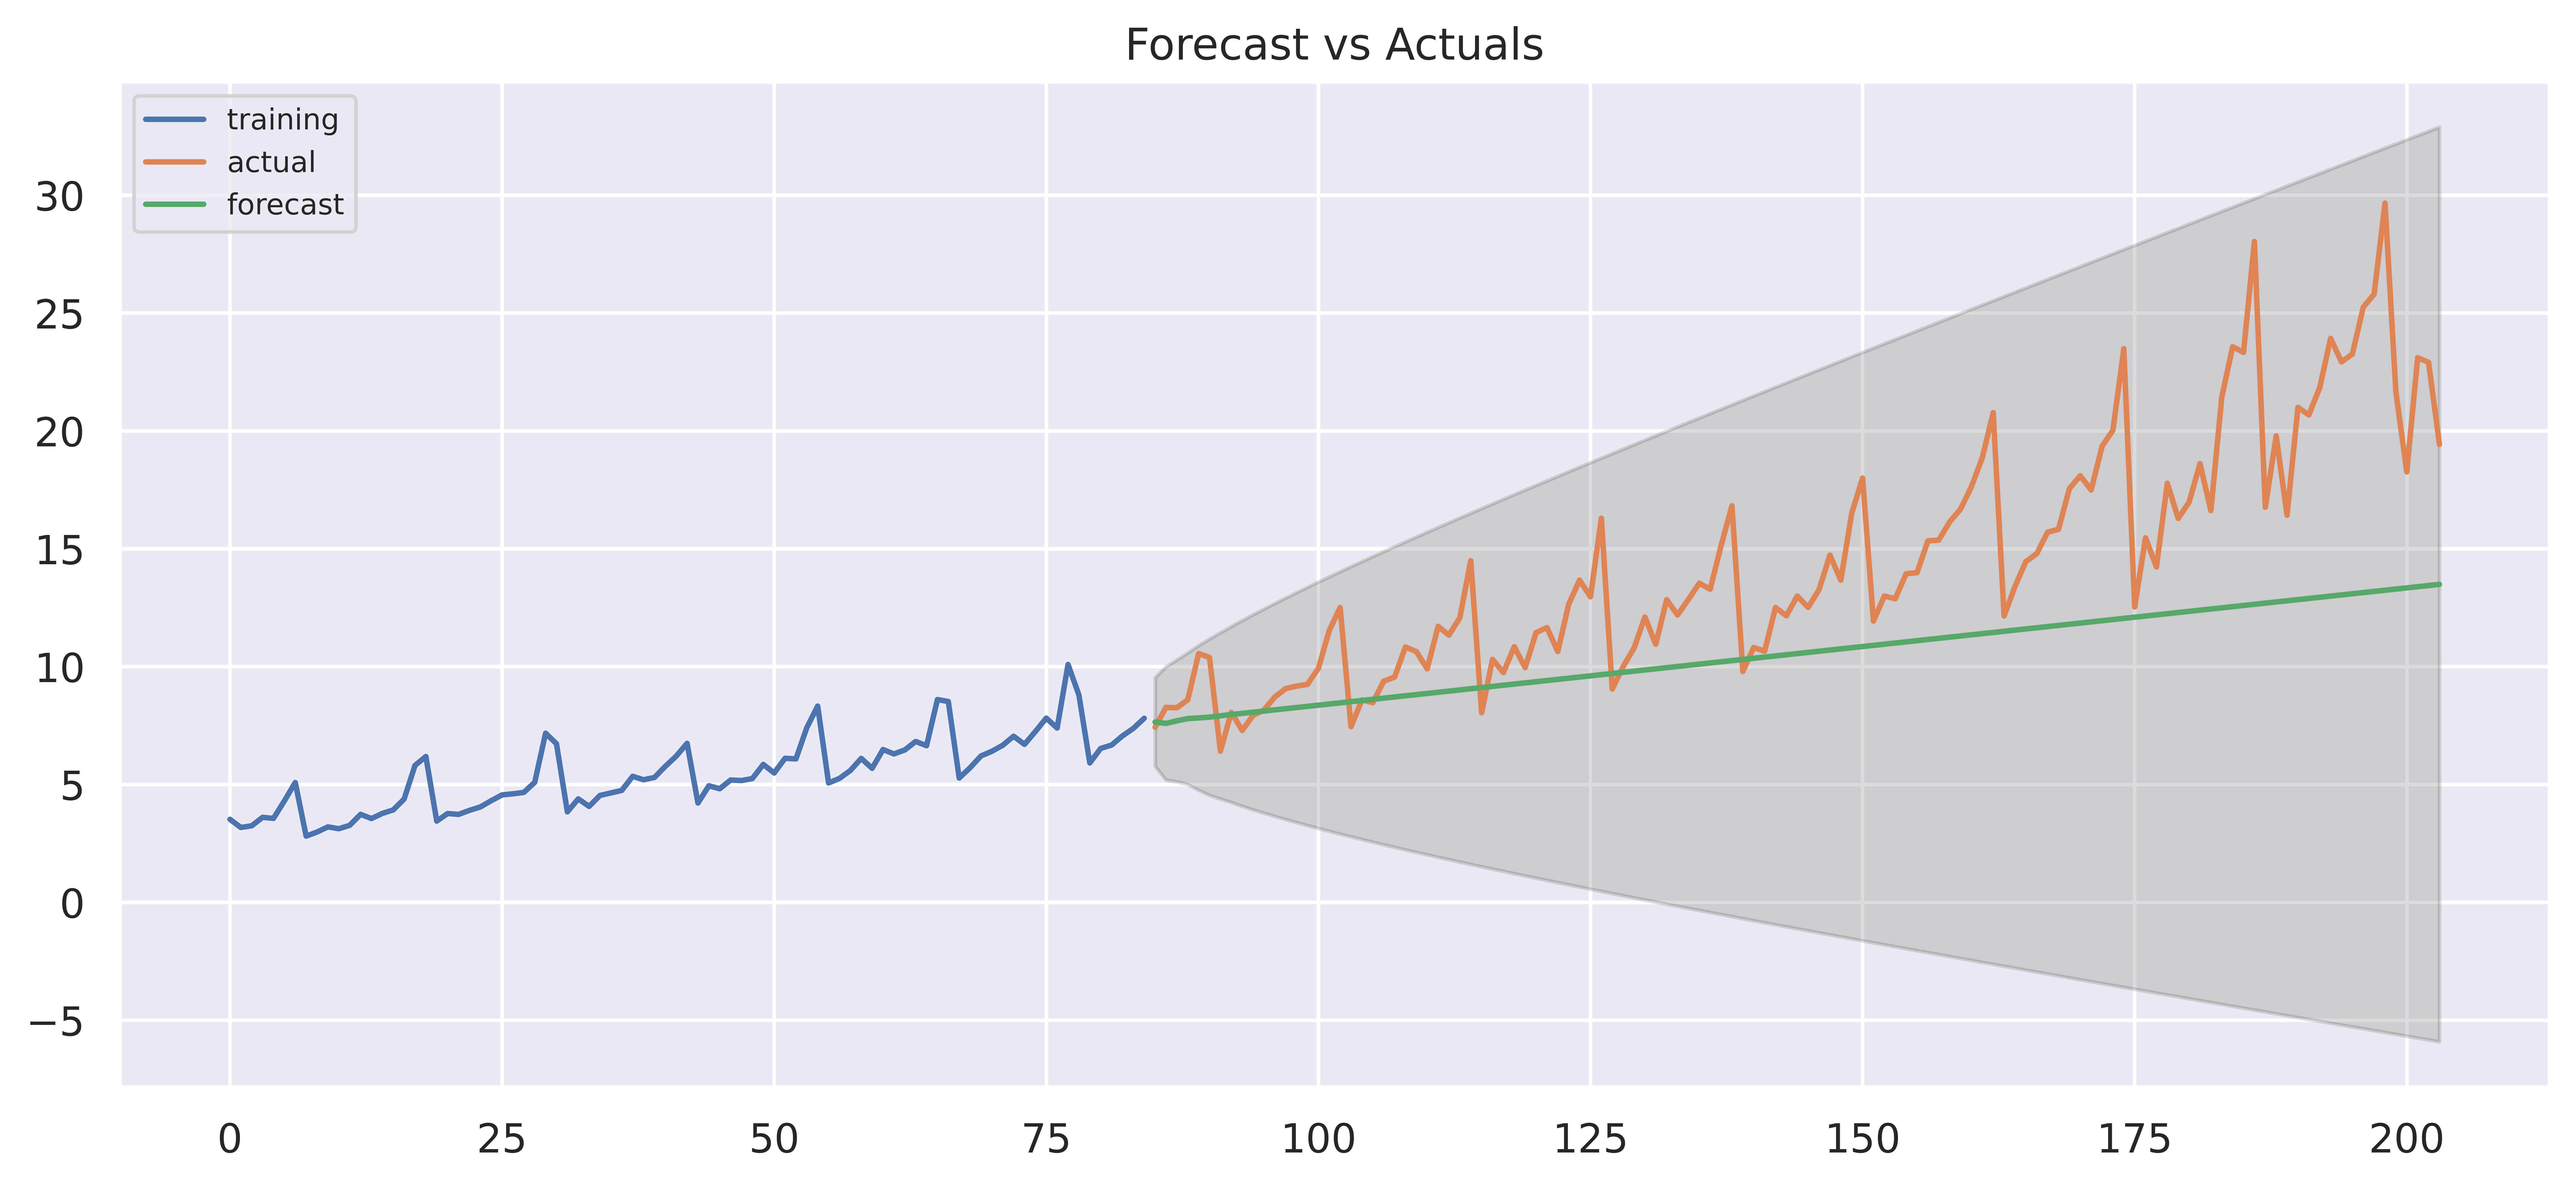

In [20]:
train = df.value[:85]
test = df.value[85:]
# Build Model
model = ARIMA(train.values, order=(3,2,1))  
fitted_3_2_1 = model.fit()

# Forecast
forecast_results = fitted_3_2_1.get_forecast(119) 
fc = forecast_results.predicted_mean
conf_int = forecast_results.conf_int(alpha=0.05)  # alpha=0.05 for 95% CI

lower_ci = pd.Series([i[0] for i in conf_int], index = test.index)
upper_ci = pd.Series([i[1] for i in conf_int], index = test.index)

fc_series = pd.Series(fc, index=test.index)
# Make as pandas series
plt.figure(figsize=(12,5), dpi=1000)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.fill_between(lower_ci.index, lower_ci, upper_ci, color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
print(fitted_3_2_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -116.886
Date:                Mon, 22 Jul 2024   AIC                            243.771
Time:                        09:57:22   BIC                            255.865
Sample:                             0   HQIC                           248.630
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2205      0.194     -1.139      0.255      -0.600       0.159
ar.L2         -0.3436      0.141     -2.444      0.015      -0.619      -0.068
ar.L3         -0.0937      0.252     -0.371      0.7

In [22]:
print(fitted_1_1_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -112.630
Date:                Mon, 22 Jul 2024   AIC                            231.260
Time:                        09:57:33   BIC                            238.552
Sample:                             0   HQIC                           234.191
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4213      0.246      1.709      0.087      -0.062       0.904
ma.L1         -0.8659      0.125     -6.943      0.000      -1.110      -0.621
sigma2         0.8485      0.098      8.635      0.0

In [23]:
pd.DataFrame({'AIC':[fitted_1_1_1.aic, fitted_3_2_1.aic], 'BIC':[fitted_1_1_1.bic, fitted_3_2_1.bic]}, index= ['ARIMA(1,1,1)', 'ARIMA(3,2,1)'])

,AIC,BIC
"ARIMA(1,1,1)",231.259595,238.552046
"ARIMA(3,2,1)",243.771009,255.865212


Clearly the ARIMA model of order (1,1,1) has a lower AIC and BIC so is a better model
<br>
<br>
We can automate the process of test across ARIMA models with difference order combinations using the **auto_arima()** method from the **pmdarima** package

In [24]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.4 MB/s eta 0:00:0000:0100:01


In [25]:
import pmdarima as pm

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=874.416, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1602.665, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=913.571, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1392.713, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=865.809, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.147, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=871.437, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=868.483, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.292, Time=0.45 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=859.374, Time=0.47 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=860.869, Time=0.40 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -423.146
Date:                Mon, 22 Jul 2024   AIC                            858.292
Time:                        09:58:21   BIC                            878.201
Sample:                             0   HQIC                           866.345
                                - 204                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3669      0.104      3.535      0.000       0.164       0.570
ar.L2          0.9964      0.038     26.244      0.000       0.922       1.071
ar.L3         -0.3639      0.090     -4.049      0.000      -0.540      -0.188
ma.L1          0.1395      0.089      1.565      0.118      -0.035       0.314
ma.L2         -0.8205      0.070    -11.736      0.000      -0.958      -0.683
sigma2         3.6034      0.310     11.641      0.000       2.997       4.210
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               119.31
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               9.49   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

To automatiically plot the residual diagrams, you can use the method, **plot_diagnostics**

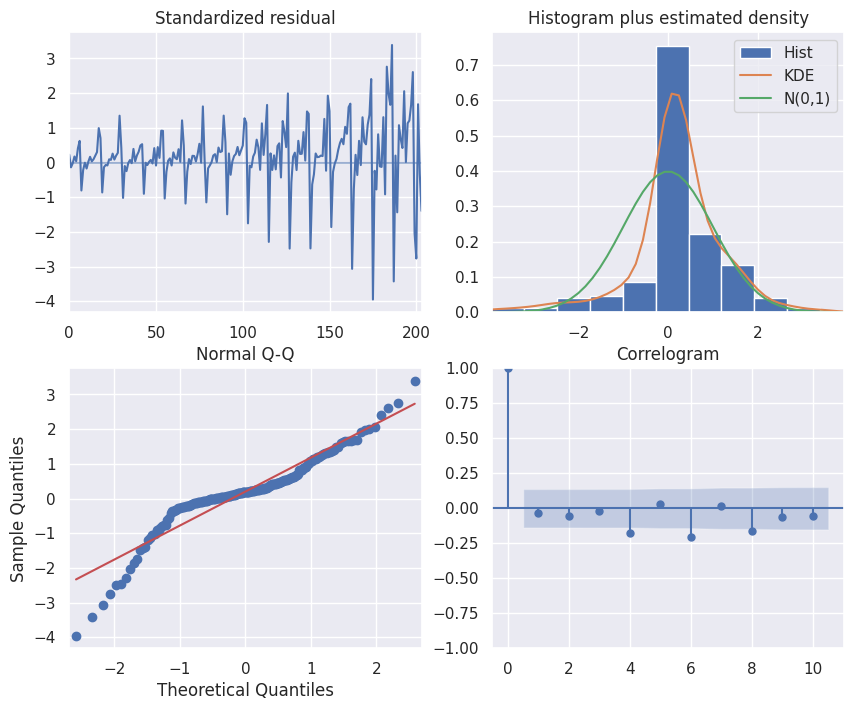

In [26]:
model.plot_diagnostics(figsize=(10,8))
plt.show()